In [1]:
# Import the required packages
import numpy as np
# from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
# from collections import OrderedDict
import matplotlib.pyplot as plt

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


# RNN Model Class and Optimizer

In [2]:
class Drosophila_RNN(nn.Module):
    def __init__(self, KC_size=200, MBON_size=20, DAN_size=20, FBN_size=60, ext_size=2, out_size=1, net_seed=1234):
        super(Drosophila_RNN, self).__init__()
        # Set the seeds
#         np.random.seed(net_seed)
#         torch.manual_seed(net_seed)
        # Set constants
        self.KC_MBON_min = 0. # Minimum synaptic weight
        self.KC_MBON_max = 0.05 # Maximum synaptic weight
        self.tau_w = 5 # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1 # Time scale of output circuitry activity
        # Set the sizes of layers
        self.N_KC = KC_size
        self.N_MBON = MBON_size
        self.N_FBN = FBN_size
        self.N_DAN = DAN_size
        self.N_recur = MBON_size + FBN_size + DAN_size
        self.N_ext = ext_size
        self.N_out = out_size
        # Define updatable network parameters
#         seed_num = net_seed
        seed_num = None
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_MBON = torch.zeros((self.N_recur, MBON_size))
        mean_FBN = torch.zeros((self.N_recur, FBN_size))
        mean_DAN = torch.zeros((self.N_recur, DAN_size))
        W_MBON = torch.normal(mean_MBON, torch.sqrt(1 / (sqrt2 * MBON_size)), generator=seed_num)
        W_FBN = torch.normal(mean_FBN, torch.sqrt(1 / (sqrt2 * FBN_size)), generator=seed_num)
        W_DAN = torch.normal(mean_DAN, torch.sqrt(1 / (sqrt2 * DAN_size)), generator=seed_num)
        self.W_recur = nn.Parameter(torch.cat((W_MBON, W_FBN, W_DAN), dim=1), requires_grad=True)
        self.W_ext = nn.Parameter(torch.randn(FBN_size, ext_size), requires_grad=True)
        mean_readout = torch.zeros((out_size, MBON_size))
        std_readout = 1 / torch.sqrt(torch.tensor(MBON_size, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout, generator=seed_num), requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.N_recur) * 0.1, requires_grad=True)
        
#         def KC_MBON_update(self, KC_trace):
#             """ Updates the synaptic weights from the Keyon cells to the output neurons.
#             Updates the synaptic connections between inputs (KCs) and output neurons (MBONs) using a LTP/LTD
#             rule (see Figure 1B of Jiang 2020). Models dopamine-gated neural plasticity on short time scale.
#             The KC->MBON weights are constrained to the range [0, 0.05].
            
#             Paramters
#                 wt = dynamic weight update variable (see Eq 4 of Jiang 2020)
#             """
            
#             self.W_KC_MBON = (-self.W_KC_MBON + wt) / self.tau_W
#             # Constrain weights to lie in [0, 0.05]
#             pass
            
            
    def forward(self, r_KC, r_ext, time, W0=None, batch_size=30):
        """ Defines the forward pass of the RNN

        Inputs
            r_KC = activity of the Kenyon cell neurons (representing odors)
            r_ext = context signals (representing the conditioning context)
            time = time vector for a single interval

        Returns
            r_recur torch.ndarray((N_MBON + N_FBN + N_DAN), time.size)
                = time series of activities in the output circuitry
            Wt torch.ndarray((N_MBON + N_FBN + N_DAN), time.size)
                = time series of KC->MBON weights (represent dopaminergic plasticity)
            readout torch.ndarray(time.size)
                = time series of valence readouts (represents behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        r_init = torch.ones((batch_size, self.N_recur)) * 0.1
        r_init[:, :self.N_MBON] = 0
#         r_recur = torch.zeros((batch_size, self.N_recur, time.size()[0]))
#         r_recur[:, :, 0] = r_init
        r_recur = []
        r_recur.append(r_init)

        # Initialize the eligibility traces, dynamic weights and readout
        r_bar_KC = r_KC[:, :, 0]
#         r_bar_DAN = r_recur[:, -self.N_DAN:, 0]
        r_bar_DAN = r_recur[-1][:, -self.N_DAN:]
#         wt = torch.zeros((batch_size, self.N_MBON, self.N_KC, time.size()[0]))
        wt = []
        wt.append(torch.zeros((batch_size, self.N_MBON, self.N_KC)))
#         W_KC_MBON = torch.zeros((batch_size, self.N_MBON, self.N_KC, time.size()[0]))
#         if W0 is None:
#             W_KC_MBON[:, :, :, 0] = W0
#         else:
#             W_KC_MBON[:, :, :, 0] = self.KC_MBON_max
#         readout = torch.zeros((batch_size, time.size()[0]))
        W_KC_MBON = []
        if W0 is None:
            W0 = torch.ones((batch_size, self.N_MBON, self.N_KC)) * self.KC_MBON_max
        W_KC_MBON.append(W0)
#         if W0 is None:
#             W_KC_MBON.append(torch.ones((batch_size, self.N_MBON, self.N_KC)) * self.KC_MBON_max)
#         else:
#             W_KC_MBON.append(W0)
        readout = []
        readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.N_MBON])))

        # Set the weights DAN->MBON to zero
#         self.W_recur[:self.N_MBON, -self.N_DAN:] = 0
        W_recur_mod = self.W_recur.clone()
        W_recur_mod[:self.N_MBON, -self.N_DAN:] = 0
#         W_recur_temp = self.W_recur
#         W_recur_temp[:self.N_MBON, -self.N_DAN:] = 0
#         W_recur_mod = W_recur_temp.clone()

        # Update activity for each time step
        for t in range(time.size()[0] - 1):
            # Define the input to the output circuitry
#             I_KC_MBON = torch.einsum('bmk, bk -> bm', W_KC_MBON[:, :, :, t], r_KC[:, :, t])
            I_KC_MBON = torch.einsum('bmk, bk -> bm', W_KC_MBON[-1], r_KC[:, :, t])
            I_FBN = torch.einsum('bfe, be -> bf', self.W_ext.repeat(batch_size, 1, 1), r_ext[:, :, t])
            I = torch.zeros((batch_size, self.N_recur))
            I[:, :self.N_MBON] = I_KC_MBON
            I[:, self.N_MBON:self.N_MBON + self.N_FBN] = I_FBN

            # Update the output circuitry activity
#             Wr_prod = torch.einsum('bsr, br -> bs', self.W_recur.repeat(batch_size, 1, 1), r_recur[:, :, t])
            Wr_prod = torch.einsum('bsr, br -> bs', W_recur_mod.repeat(batch_size, 1, 1), r_recur[-1])
#             dr = F.relu(-r_recur[:, :, t] + Wr_prod + self.bias.repeat(batch_size, 1) + I) / self.tau_r
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(batch_size, 1) + I)) / self.tau_r
#             r_recur[:, :, t+1] = r_recur[:, :, t] + dr * dt
            r_recur.append(r_recur[-1] + dr * dt)

            # Update KC->MBON plasticity variables
            # Calculate the eligibility traces
            r_bar_KC = r_bar_KC + (r_KC[:, :, t] - r_bar_KC) * dt / self.tau_w
#             r_bar_DAN = (r_recur[:, -self.N_DAN:, t] - r_bar_DAN) * dt / self.tau_w
            r_bar_DAN = r_bar_DAN + (r_recur[-1][:, -self.N_DAN:] - r_bar_DAN) * dt / self.tau_w
            # Update the dynamic weight variable
            prod1 = torch.einsum('bd, bk -> bdk', r_bar_DAN, r_KC[:, :, t])
#             prod2 = torch.einsum('bd, bk -> bdk', r_recur[:, -self.N_DAN:, t], r_bar_KC)
            prod2 = torch.einsum('bd, bk -> bdk', r_recur[-1][:, -self.N_DAN:], r_bar_KC)
            dw = (prod1 - prod2)
#             wt[:, :, :, t+1] = wt[:, :, :, t] + dw * dt
#             # Update the KC->MBON weights
#             dW = (-W_KC_MBON[:, :, :, t] + wt[:, :, :, t+1]) / self.tau_w
#             W_tp1 = W_KC_MBON[:, :, :, t] + dW * dt
#             # Clip the KC->MBON weights to the range [0, 0.05]
#             W_KC_MBON[:, :, :, t+1] = torch.clamp(W_tp1, self.KC_MBON_min, self.KC_MBON_max)
            wt.append(wt[-1] + dw * dt)
            # Update the KC->MBON weights
            dW = (-W_KC_MBON[-1] + wt[-1]) / self.tau_w
            W_tp1 = W_KC_MBON[-1] + dW * dt
            # Clip the KC->MBON weights to the range [0, 0.05]
            W_KC_MBON.append(torch.clamp(W_tp1, self.KC_MBON_min, self.KC_MBON_max))

            # Calculate the readout
#             readout[:, t] = torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[:, :self.N_MBON, t]))
#             readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[:, :self.N_MBON, t])))
            readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.N_MBON])))

        return r_recur, W_KC_MBON, readout
            
        
# Clipping weights between [0, 0.05]
# https://discuss.pytorch.org/t/how-to-do-constrained-optimization-in-pytorch/60122
# https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620
# https://discuss.pytorch.org/t/restrict-range-of-variable-during-gradient-descent/1933/4

# Setting DAN->MBON weights to zero
# https://pytorch.org/docs/stable/generated/torch.triu.html

# Broadcasting using einsum
# https://github.com/pytorch/pytorch/issues/15671


# Conditioning Tasks

In [3]:
# Initialize the network
classic_net = Drosophila_RNN()
for param in classic_net.parameters():
    print(param.shape)
#     print(param)
# print(classic_net.N_DAN)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(classic_net.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([60, 2])
torch.Size([1, 20])
torch.Size([100])


In [4]:
# Define the cost function for conditioning tasks
def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.
    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eq. (3) and (9) in Jiang 2020.
    
    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant
    
    Returns
        loss_tot = scalar loss used in backprop
    """
    
    # Set the baseline DAN activity
    DAN_baseline = 0.1
    
    # Calculate the MSE loss of the valence
    v_sum = torch.mean((vt - vt_opt)**2, dim=1)
    v_loss = torch.mean(v_sum)
    
    # Calculate regularization term
    r_sum = torch.sum(F.relu(r_DAN - 0.1)**2, dim=1)
    r_loss = lam * torch.mean(r_sum, dim=1)
    
    # Calculate the summed loss (size = n_batch)
    loss = v_loss + r_loss
    
    # Average the loss over all batches
    loss_tot = torch.mean(loss)
    
    return loss_tot


In [5]:
# Define a training function for first-order conditioning

In [6]:
# Initialize the simulation constants
n_batch = 30
# n_batch = 10
n_epochs = 5000
# n_epochs = 501
T_int = 30
T_stim = 2
dt = 0.5
stim_wts = torch.ones(n_batch, 22)
stim_len = int(T_stim / dt)

# Odor (CS) constants
n_KC = 200
n_ones = int(n_KC * 0.1)
KC_wts = torch.ones(n_batch, n_KC)
# Context (US) constants
n_ext = 2
ext_wts = torch.ones(n_batch, n_ext)
# Other parameters
W_KC_MBON_max = 0.05
n_MBON = 20

# List to store losses
loss_hist = []


0 0.6200157403945923
500 0.010245592333376408
1000 0.006176587659865618
1500 0.006215189583599567
2000 0.007546804845333099
2500 0.006326636299490929
3000 0.004932535346597433
3500 0.00586079154163599
4000 0.006484252400696278
4500 0.0057143718004226685


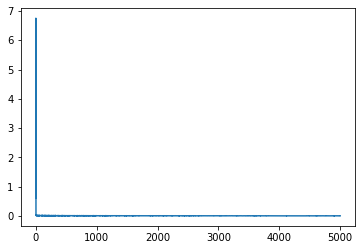

In [7]:
# Train first-order conditioning network
time_int = torch.arange(0, T_int + dt/10, dt)
n_ints = 2
clip = 0.01
for epoch in range(n_epochs):
    # Define the conditioned stimuli (CS) = odors
    r_KC_inds = torch.multinomial(KC_wts, n_ones)
    r_KC = torch.zeros(n_batch, n_KC)
    for b in range(n_batch):
        r_KC[b, r_KC_inds[b, :]] = 1
        
    # Randomly determine whether each trial is CS+ or CS- (0 = CS+, 1 = CS-)
    cs_trials = torch.multinomial(torch.ones(2), n_batch, replacement=True)
    # Define the unconditioned stimuli (US) = context
    r_ext = torch.multinomial(ext_wts, n_ext)
#     r_ext[cs_trials == 0] = 0
#     print(r_ext)
    
    # Randomly determine the time of each stimulus presentation
    stim_times = torch.multinomial(stim_wts, n_ints, replacement=True) + 10
    
    # Make a list to store activities and valences
    r_outs = []
    vts = []
    Wts = []
    vals = []
    
    # Initial KC->MBON weight value
    W_KC_MBON = torch.ones((n_batch, n_MBON, n_KC)) * W_KC_MBON_max
    
    # Determine whether CS or US are randomly omitted
    p_omit = 0.5 # Fraction of trials with CS or US omitted (i.e (1-p) of CS+ trials)
    omit_inds = torch.rand(n_batch) > p_omit
#     omit_inds = torch.zeros(n_batch) > p_CSp
    # If omitted, determine which one is omitted
    p_omit_CS = 0.7 # Fraction of omitted trials being CS omitted
    x_omit_CS = torch.rand(n_batch)
    omit_CS_inds = torch.logical_and(omit_inds, x_omit_CS < p_omit_CS)
    omit_US_inds = torch.logical_and(omit_inds, x_omit_CS > p_omit_CS)
    
    # For each interval
    for i in range(n_ints):
        # Define a binary CS and US time series to mulitply the inputs by
        time_CS = torch.zeros(n_batch, time_int.size()[0])
        time_US = torch.zeros_like(time_CS)
        val_int = torch.zeros_like(time_CS)
        for b in range(n_batch):
            if not omit_CS_inds[b]:
                stim_inds = stim_times[b, i] + torch.arange(stim_len)
                time_CS[b, stim_inds] = 1
            if i == 0 and not omit_US_inds[b]:
                stim_inds = stim_times[b, i] + torch.arange(stim_len) + stim_len
                time_US[b, stim_inds] = 1
            if i == 1 and not omit_inds[b]:
                stim_inds = stim_times[b, i] + torch.arange(stim_len)
                if r_ext[b, 0] == 1:
                    val_int[b, stim_inds] = 1
                else:
                    val_int[b, stim_inds] = -1

#             stim_inds = stim_times[b, i] + torch.arange(stim_len)
#             time_CS[b, stim_inds] = 1
#             if i == 0:
#                 stim_inds = stim_times[b, i] + torch.arange(stim_len) + stim_len
#                 time_US[b, stim_inds] = 1
#             if i == 1 and cs_trials[b] == 1:
#                 stim_inds = stim_times[b, i] + torch.arange(stim_len)
#                 val_int[b, stim_inds] = 1
# #                 if r_ext[b, 0] == 1:
# #                     val_int[b, stim_inds] = 1
# #                 else:
# #                     val_int[b, stim_inds] = -1
                
        r_KCt = torch.einsum('bm, mbt -> bmt', r_KC, time_CS.repeat(n_KC, 1, 1))
        r_extt = torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
        
        # Run the forward model
        r_int, W_KC_MBON_ls, vt = classic_net(r_KCt, r_extt, time_int, W0=W_KC_MBON, batch_size=n_batch)
        W_KC_MBON = W_KC_MBON_ls[-1]
        r_outs += r_int
        vts += vt
        Wts += W_KC_MBON_ls
        vals.append(val_int)
        
    # Concatenate the activities and valences
    r_out_epoch = torch.stack(r_outs, dim=-1)
    vt_epoch = torch.stack(vts, dim=-1)
    Wt_epoch = torch.stack(Wts, dim=-1)
    vt_opt = torch.cat((vals[0], vals[1]), dim=-1)

    # Define the target valence
#     vt_opt = torch.cat((torch.zeros_like(time_CS), time_CS), dim=1)
    
    # Calculate the loss
#     print(vt_epoch.shape)
#     print(vt_opt.shape)
    loss = cond_loss(vt_epoch, vt_opt, r_out_epoch[:, -classic_net.N_DAN:, :])
#     print(loss)
    
    # Update the network parameters
    optimizer.zero_grad()
#     torch.autograd.set_detect_anomaly(True)
    loss.backward()
#     total_norm = 0
#     for param in classic_net.parameters():
#         param_norm = param.grad.data.norm(2)
#         total_norm += param_norm.item()**2
#     print(total_norm**(1 / 2))
    torch.nn.utils.clip_grad_norm_(classic_net.parameters(), clip)
    optimizer.step()
    
    # Print an update
    if epoch % 500 == 0:
        print(epoch, loss.item())
    loss_hist.append(loss.item())

plt.plot(loss_hist);

# https://discuss.pytorch.org/t/proper-way-to-do-gradient-clipping/191/13
# https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48
# https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961


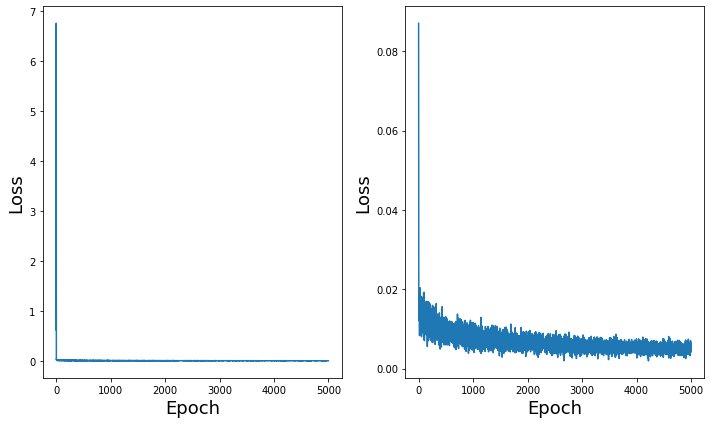

In [8]:
# Plot the loss function
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(loss_hist)
axes[0].set_xlabel('Epoch', fontsize=label_font)
axes[0].set_ylabel('Loss', fontsize=label_font)
axes[1].plot(loss_hist[2:])
axes[1].set_xlabel('Epoch', fontsize=label_font)
axes[1].set_ylabel('Loss', fontsize=label_font)
fig.tight_layout();


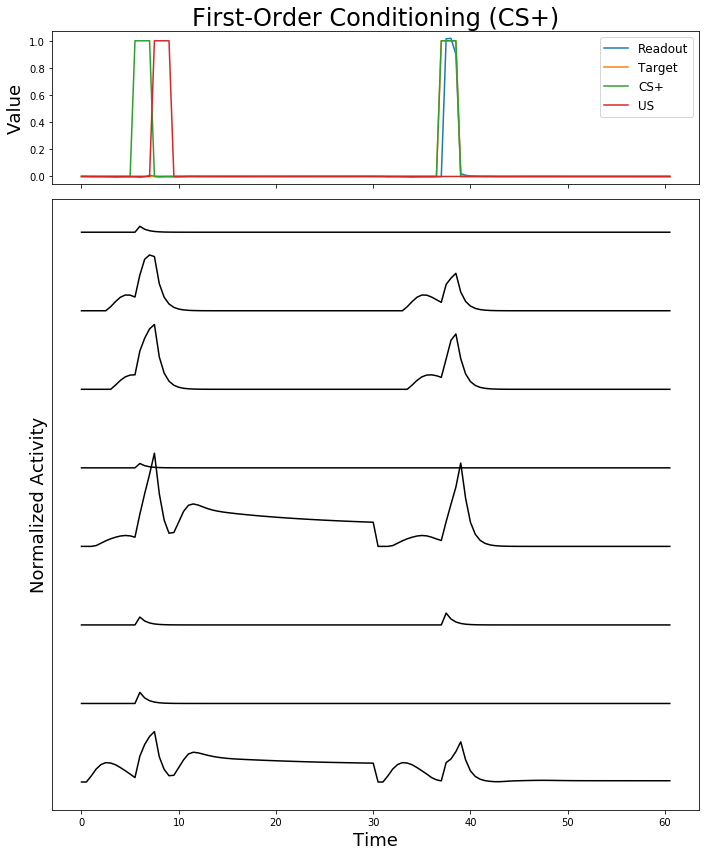

In [11]:
# Plot some results to compare to Fig 2A/B in paper
# Create a first-order conditioning trial (CS+)
r_KC = torch.zeros(1, n_KC)
r_KC_inds = torch.multinomial(torch.ones(n_KC), n_ones)
# print(r_KC_inds.size()[0])
r_KC[0, r_KC_inds] = 1
# print(r_KC)
r_ext = torch.tensor([1, 0]).view(1, -1)
# stim_times = torch.multinomial(torch.ones(22), 1) + 10
stim_times = torch.multinomial(torch.ones(1, 22), n_ints, replacement=True) + 10

# Make a list to store activities, valences and stimulus times
r_outs = []
vts = []
Wts = []
ls_CS = []
ls_US = []

# Initial KC->MBON weight value
n_MBON = 20
W_KC_MBON = torch.ones((1, n_MBON, n_KC)) * W_KC_MBON_max

for i in range(n_ints):
    # Define a binary CS and US time series to mulitply the inputs by
    time_CS = torch.zeros(1, time_int.size()[0])
    time_US = torch.zeros_like(time_CS)
    stim_inds = stim_times[0, i] + torch.arange(stim_len)
    time_CS[0, stim_inds] = 1
    if i == 0:
        stim_inds = stim_times[0, i] + torch.arange(stim_len) + stim_len
        time_US[0, stim_inds] = 1
    r_KCt = torch.einsum('bm, mbt -> bmt', r_KC, time_CS.repeat(n_KC, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
#     print(r_KCt.shape)
#     print(r_extt.shape)

    # Run the forward model
    r_int, W_KC_MBON_ls, vt = classic_net(r_KCt, r_extt, time_int, W0=W_KC_MBON, batch_size=1)
    W_KC_MBON = W_KC_MBON_ls[-1]
    r_outs += r_int
    vts += vt
    Wts += W_KC_MBON_ls
    ls_CS += time_CS
    ls_US += time_US
        
r_out_epoch = torch.stack(r_outs, dim=-1).squeeze().detach().numpy()
vt_epoch = torch.stack(vts, dim=-1).squeeze().detach().numpy()
Wt_epoch = torch.stack(Wts, dim=-1).squeeze().detach().numpy()
plot_CS = torch.cat(ls_CS).numpy()
plot_US = torch.cat(ls_US).numpy()

# Define the target valence
vt_opt = torch.cat((torch.zeros_like(time_CS), time_CS), dim=1).squeeze().detach().numpy()

# Plot the conditioning and test
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
plot_time = torch.cat((time_int, time_int + T_int + dt))
ax1.plot(plot_time, vt_epoch, label='Readout')
ax1.plot(plot_time, vt_opt, label='Target')
ax1.plot(plot_time, plot_CS, label='CS+')
ax1.plot(plot_time, plot_US, label='US')
# ax1.set_xlabel('Time', fontsize=label_font)
ax1.set_ylabel('Value', fontsize=label_font)
ax1.set_title('First-Order Conditioning (CS+)', fontsize=title_font)
ax1.legend(fontsize=legend_font)

# Normalize the KC->MBON weights
Wt_epoch /= W_KC_MBON_max

# Plot the activities of a few MBONs
plot_neurs = np.random.choice(n_MBON, size=8, replace=False)
for i, n in enumerate(plot_neurs):
    ax2.plot(plot_time, r_out_epoch[n, :] + i/2, '-k')
ax2.set_xlabel('Time', fontsize=label_font)
ax2.set_ylabel('Normalized Activity', fontsize=label_font)
ax2.set_yticks([])
fig.tight_layout();


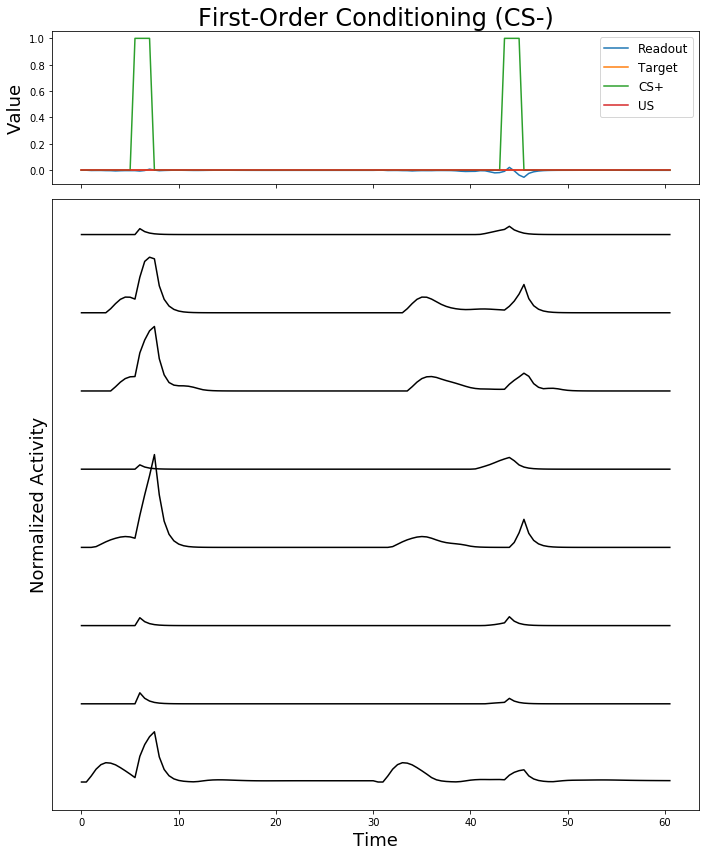

In [12]:
# Plot some results to compare to Fig 2A/B in paper
# Create a first-order conditioning trial (CS+)
r_KC = torch.zeros(1, n_KC)
r_KC_inds = torch.multinomial(torch.ones(n_KC), n_ones)
# print(r_KC_inds.size()[0])
r_KC[0, r_KC_inds] = 1
# print(r_KC)
r_ext = torch.tensor([1, 0]).view(1, -1)
# stim_times = torch.multinomial(torch.ones(22), 1) + 10
stim_times = torch.multinomial(torch.ones(1, 22), n_ints, replacement=True) + 10

# Make a list to store activities, valences and stimulus times
r_outs = []
vts = []
Wts = []
ls_CS = []
ls_US = []

# Initial KC->MBON weight value
n_MBON = 20
W_KC_MBON = torch.ones((1, n_MBON, n_KC)) * 0.05

for i in range(n_ints):
    # Define a binary CS and US time series to mulitply the inputs by
    time_CS = torch.zeros(1, time_int.size()[0])
    time_US = torch.zeros_like(time_CS)
    stim_inds = stim_times[0, i] + torch.arange(stim_len)
    time_CS[0, stim_inds] = 1
#     if i == 0:
#         stim_inds = stim_times[0, i] + torch.arange(stim_len) + stim_len
#         time_US[0, stim_inds] = 1

    r_KCt = torch.einsum('bm, mbt -> bmt', r_KC, time_CS.repeat(n_KC, 1, 1))
    r_extt = torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
#     print(r_KCt.shape)
#     print(r_extt.shape)

    # Run the forward model
    r_int, W_KC_MBON_ls, vt = classic_net(r_KCt, r_extt, time_int, W0=W_KC_MBON, batch_size=1)
    W_KC_MBON = W_KC_MBON_ls[-1]
    r_outs += r_int
    vts += vt
    Wts += W_KC_MBON_ls
    ls_CS += time_CS
    ls_US += time_US
        
r_out_epoch = torch.stack(r_outs, dim=-1).squeeze().detach().numpy()
vt_epoch = torch.stack(vts, dim=-1).squeeze().detach().numpy()
Wt_epoch = torch.stack(Wts, dim=-1).squeeze().detach().numpy()
plot_CS = torch.cat(ls_CS).numpy()
plot_US = torch.cat(ls_US).numpy()

# Define the target valence
vt_opt = torch.cat((torch.zeros_like(time_CS), time_US), dim=1).squeeze().detach().numpy()

# Plot the conditioning and test
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
plot_time = torch.cat((time_int, time_int + T_int + dt))
ax1.plot(plot_time, vt_epoch, label='Readout')
ax1.plot(plot_time, vt_opt, label='Target')
ax1.plot(plot_time, plot_CS, label='CS+')
ax1.plot(plot_time, plot_US, label='US')
# ax1.set_xlabel('Time', fontsize=label_font)
ax1.set_ylabel('Value', fontsize=label_font)
ax1.set_title('First-Order Conditioning (CS-)', fontsize=title_font)
ax1.legend(fontsize=legend_font)

# Normalize the KC->MBON weights
Wt_epoch /= 0.05

# Plot the activities of a few MBONs
for i, n in enumerate(plot_neurs):
    ax2.plot(plot_time, r_out_epoch[n, :] + i/2, '-k')
ax2.set_xlabel('Time', fontsize=label_font)
ax2.set_ylabel('Normalized Activity', fontsize=label_font)
ax2.set_yticks([])
fig.tight_layout();
